In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib
import sklearn
import os
import re
import math
from matplotlib import pyplot as plt

### read from file

In [2]:
filePath = 'G:\\MIE1624\\A2'
# use first line as header
original_data = pd.read_csv(os.path.join(filePath,'Kaggle_Salary.csv'),header=1)

# drop index col
original_data = original_data.drop(columns = ["0"])
original_data.head()

D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (209,323,372,385,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,...,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too expensive,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too time-consuming,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Requires too much technical knowledge,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Afraid that others will use my work without giving proper credit,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Not enough incentives to share my work,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - I had never considered making my work easier for others to reproduce,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - None of these reasons apply to me,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Other,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Other - Text,Unnamed: 396
0,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
1,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
2,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
3,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,Academics/Education,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
4,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,Other,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0


# 1. clear data

## 1.0 choice subset on original dataset

find out where are those subjects' place of residence

In [3]:
original_data["In which country do you currently reside?"].unique()

array(['Indonesia', 'United States of America', 'India', 'Chile',
       'Hungary', 'France', 'Argentina', 'Japan', 'Colombia', 'Nigeria',
       'Spain', 'Other', 'Iran, Islamic Republic of...',
       'United Kingdom of Great Britain and Northern Ireland', 'Turkey',
       'Poland', 'Kenya', 'Denmark', 'Netherlands', 'Sweden', 'Ukraine',
       'Canada', 'Australia', 'Russia', 'Italy', 'Mexico', 'Germany',
       'I do not wish to disclose my location', 'Singapore', 'Brazil',
       'China', 'South Africa', 'South Korea', 'Malaysia',
       'Hong Kong (S.A.R.)', 'Portugal', 'Thailand', 'Morocco',
       'Pakistan', 'Tunisia', 'Ireland', 'Israel', 'Switzerland',
       'Bangladesh', 'Romania', 'Austria', 'Belarus', 'Viet Nam',
       'Czech Republic', 'Philippines', 'Belgium', 'New Zealand',
       'Norway', 'Finland', 'Egypt', 'Greece', 'Peru',
       'Republic of Korea'], dtype=object)

So from above, we can see people from all over the world have taken this survey.

But for me, I only instersted in the survey subjects that live in China, Hong Kong, India, Japan, Korea, Canada, America

The reason why I want to choose those countries as data of this assignment is that I am targeting to find data analysis related job in those countries after finishing my master dregee. To choose China, Japan, Korea, India is because I born in east Asian I may go back to east Asian after graduated. But meanwhile, I may also stay here to seek for job. That's why I also including Canada, America.

In [4]:
# extract samples which are filled by subjects coming from China, India, Japan, Korea, Canada, America.
target_contries = ['China', 'India', 'Japan', 'South Korea', 'Republic of Korea', 'Hong Kong (S.A.R.)', 'Canada', 'United States of America']
data = original_data.loc[original_data["In which country do you currently reside?"].isin(target_contries)]
print(data["In which country do you currently reside?"].unique())
print("Size of subset data:", data.shape[0])
print("Szie of subset data:", data.shape)

['United States of America' 'India' 'Japan' 'Canada' 'China' 'South Korea'
 'Hong Kong (S.A.R.)' 'Republic of Korea']
Size of subset data: 7638
Szie of subset data: (7638, 396)


So the size of subnet is 7638, which is bigger that minimze requirement(5000). Therefore I will continue assignment with this sub-dataset.

## 1.1 filling the missing values and conversion
### From my observation, there are 2 type of missing value:
### 1. subjects did fill the questions left a missing value.

To handle first type of missing values, I will fill them will the mode of that column. 
The reason is that for most of the rows, only a few questions weren't answered, therefore directly delete them will lost lots of data. Fill they with mode of that column is a easy way to get rid of missing value and keep the advantage of majority of data.

Hower fill them with mode of that column will change the distribution of data, but once again, only a few question weren't answered, so the impact will be slightly.

### 2. some columns indicate subjects' choice of selections, if subjects did choice that selection, it will filled with  a nan value.

To handle second type of missing values, I will directly replace the missing value with 0. Since all those nan value simple indicate subject didn't choose this selection. Therefore replace them with 0 will have no negative impact on data. 

From my observation:
1. the first type of missing values show up in numerical columns and undummy categorical columns: like "During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Visualizing data" and "Select the title most similar to your current role (or most recent title if retired): - Selected Choice"


2. the second type of missing values show up in dummy categorical columns: like "What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too expensive"

### * All dummy categorical columns will contain "- Selected Choice -" in the question.

###  firstly, convert missing value in dummy categorical columns into 0

In [5]:
# get all dummy categorical data columns
total_cols = data.columns
already_dummy_cate_cols = []
for col in total_cols:
    if re.search(r'- Selected Choice -',col):
        already_dummy_cate_cols.append(col)
        
# convert missing values in dummy categorical columns into 0
def convert(item):
    if item != item:
        return 0
    else:
        return 1
for col in already_dummy_cate_cols:
    data[col] = data[col].apply(convert)
data.head()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,...,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too expensive,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Too time-consuming,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Requires too much technical knowledge,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Afraid that others will use my work without giving proper credit,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Not enough incentives to share my work,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - I had never considered making my work easier for others to reproduce,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - None of these reasons apply to me,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Selected Choice - Other,What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Other - Text,Unnamed: 396
1,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,0,1,0,0,0,0,0,0,-1,1.0
2,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,0,1,0,0,1,0,0,0,-1,2.0
4,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,Other,...,0,0,0,0,1,0,0,0,-1,4.0
6,823,Male,-1,40-44,United States of America,Master’s degree,Engineering (non-computer focused),Data Scientist,-1,Other,...,0,1,0,0,1,0,0,0,-1,6.0
8,1917,Male,-1,25-29,United States of America,Bachelor’s degree,Mathematics or statistics,Research Assistant,-1,Academics/Education,...,0,1,0,0,0,0,0,0,-1,8.0


### secondly, replace missing value in numerical columns and undummy categorical columns with mode of the columns

In [6]:
# get all other columns 
num_cols_and_undummy_cate_cols = list(set(total_cols)-set(already_dummy_cate_cols))
cols_with_nan = []
for i in num_cols_and_undummy_cate_cols:
    for j in data[i].unique():
        if j != j:
            cols_with_nan.append(i)
            break
for col in cols_with_nan:
    data[col].fillna(data[col].mode()[0],inplace=True)
data[cols_with_nan].head()

D:\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice,What do you find most difficult about ensuring that your algorithms are fair and unbiased? (Select all that apply) - Lack of communication between individuals who collect the data and individuals who analyze the data,What do you find most difficult about ensuring that your algorithms are fair and unbiased? (Select all that apply) - Difficulty in identifying and selecting the appropriate evaluation metrics,What do you find most difficult about ensuring that your algorithms are fair and unbiased? (Select all that apply) - Difficulty in identifying groups that are unfairly targeted,What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Self-taught,What methods do you prefer for explaining and/or interpreting decisions that are made by ML models? (Select all that apply) - Other - Text,Which best describes your undergraduate major? - Selected Choice,What do you find most difficult about ensuring that your algorithms are fair and unbiased? (Select all that apply) - I have never found any difficulty in this task,What specific programming language do you use most often? - Selected Choice,What is the type of data that you currently interact with most often at work or school? - Selected Choice,...,How do you perceive the importance of the following topics? - Being able to explain ML model outputs and/or predictions,How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions? - In-person bootcamps:,What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Kaggle competitions,"During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Model building/model selection","Do you consider ML models to be ""black boxes"" with outputs that are difficult or impossible to explain?",What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,What do you find most difficult about ensuring that your algorithms are fair and unbiased? (Select all that apply) - Difficulty in collecting enough data about groups that may be unfairly targeted,For how many years have you used machine learning methods (at work or in school)?,What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - University,"Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice"
1,Python,Lack of communication between individuals who ...,Difficulty in identifying and selecting the ap...,Difficulty in identifying groups that are unfa...,0.0,Activation Maps,"Computer science (software engineering, etc.)",I have never found any difficulty in this task,Java,Time Series Data,...,Very important,Slightly better,0.0,50.0,I am confident that I can explain the outputs ...,Local or hosted development environments (RStu...,Difficulty in collecting enough data about gro...,< 1 year,100.0,Scikit-Learn
2,R,Lack of communication between individuals who ...,Difficulty in identifying and selecting the ap...,Difficulty in identifying groups that are unfa...,20.0,Activation Maps,Mathematics or statistics,I have never found any difficulty in this task,SQL,Numerical Data,...,Slightly important,Much better,0.0,10.0,I am confident that I can understand and expla...,"Advanced statistical software (SPSS, SAS, etc.)",Difficulty in collecting enough data about gro...,2-3 years,20.0,Scikit-Learn
4,Python,Lack of communication between individuals who ...,Difficulty in identifying and selecting the ap...,Difficulty in identifying groups that are unfa...,75.0,Activ

## 1.2 convert categorical data into numerical data by encoding and explain why you used this particular encoding method.

I will use one-hot coding to convert categorical data into numerical data. 

First of all, it's a widely used encoding method in machine learning area for it's advantage of stable behavior. And then it's also easy to implement using pandas.

In [7]:
# get all categorical data columns
total_cols = data.columns
num_cols = data._get_numeric_data().columns
undummy_cate_cols = list(set(total_cols)-set(num_cols))

In [8]:
for col in undummy_cate_cols:
    tmp = pd.get_dummies(data[col], prefix = 'dummy_'+col)
    data = data.join(tmp)
data = data.drop(undummy_cate_cols, axis = 1)
data.head()

,Duration (in seconds),What is your gender? - Prefer to self-describe - Text,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,What is your current yearly compensation (approximate $USD)?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,...,"dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Prophet","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_PyTorch","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Scikit-Learn","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Spark MLlib","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_TensorFlow","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Xgboost","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_catboost","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_lightgbm","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_mlr","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_randomForest"
1,718,-1,-1,-1,2726,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,731,-1,-1,-1,682,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1758,-1,2,1,2696,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,823,-1,-1,2,132826,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,1917,-1,-1,-1,35826,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


### 1.3 As addition, we find that some of subjects answered all roughly 50 questions less than 200 seconds, which indicate those subjects didn't answer the question that carefully. Therefore, answers may not be so useful for regression. I decide to delete all those samples( duration less than 200)

In [9]:
data = data[data["Duration (in seconds)"] >= 200]
print("remaining number of samples:", data.shape[0])

remaining number of samples: 7168


### check data if any nan value remain.

In [10]:
tmp = []
for i in data.columns:
    for j in data[i].unique():
        if j != j:
            tmp.append(i)
            break
if tmp:
    print("nan values remain!")
else:
    print("data is good to go!")

data is good to go!


# 2. Exploratory data analysis

## 2.1 Present 3 graphical figures that represent trends in the data

### firstly, let's see the distribution of the label values

total number of labels: 7168


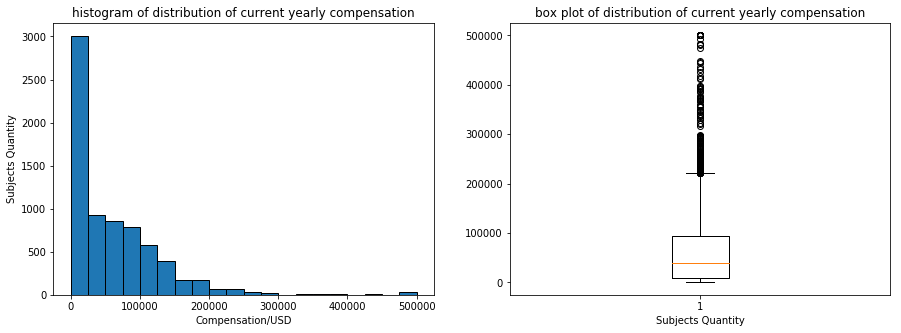

In [11]:
label = data["What is your current yearly compensation (approximate $USD)?"]
print("total number of labels:",label.shape[0])
fig,ax = plt.subplots(1,2,figsize=[15,5])

ax[0].hist(label, bins=20, edgecolor='black')
ax[0].set_title("histogram of distribution of current yearly compensation")
ax[0].set_xlabel("Compensation/USD")
ax[0].set_ylabel("Subjects Quantity")

ax[1].boxplot(label)
ax[1].set_title("box plot of distribution of current yearly compensation")
ax[1].set_xlabel("Subjects Quantity")
plt.show()

We can see that most of the labels are in range (0,100,000) as yearly compensation. Meanwhile, there are only small portion of people whose yearly compensation are higher than 200,000 USD.

This distribution indicate that our training model may only have good prediction ability on lower compensation instead of higher compensation because we don't have much data for higher compensation subjects.




### secondly, let's look into the question "What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"

What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Bachelor’s degree                                                    4383
Doctoral degree                                                      2522
I prefer not to answer                                                130
Master’s degree                                                      7286
No formal education past high school                                  135
Professional degree                                                   384
Some college/university study without earning a bachelor’s degree     589
Name: What is the highest level of formal education that you have attained or plan to attain within the next 2 years?, dtype: int64


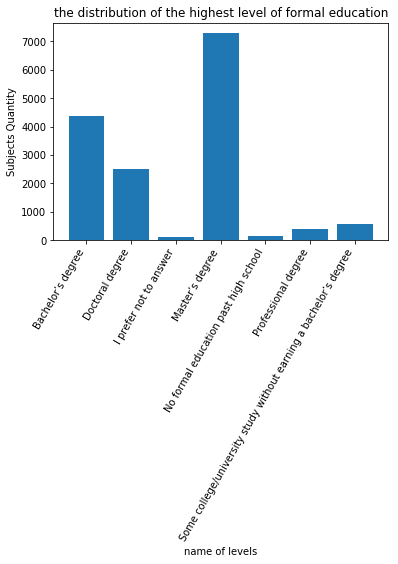

In [12]:
level_counter = original_data.groupby("What is the highest level of formal education that you have attained or plan to attain within the next 2 years?")["What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"].count()
labels = level_counter.index
counters = level_counter.values
print(level_counter)

plt.figure()
plt.bar(labels,counters)
plt.title("the distribution of the highest level of formal education")
plt.xlabel("name of levels")
plt.ylabel("Subjects Quantity")
plt.xticks(rotation=60, verticalalignment='top', horizontalalignment='right')
plt.show()

from above figure, we can see that, most of the subjects hold a university degree or higher degree. Also the distribution of the highest level of education is uneven, which means that it could be a good feature to predict yearly compensation. 

### Thirdly, let's look at the questions "What programming languages do you use on a regular basis?"

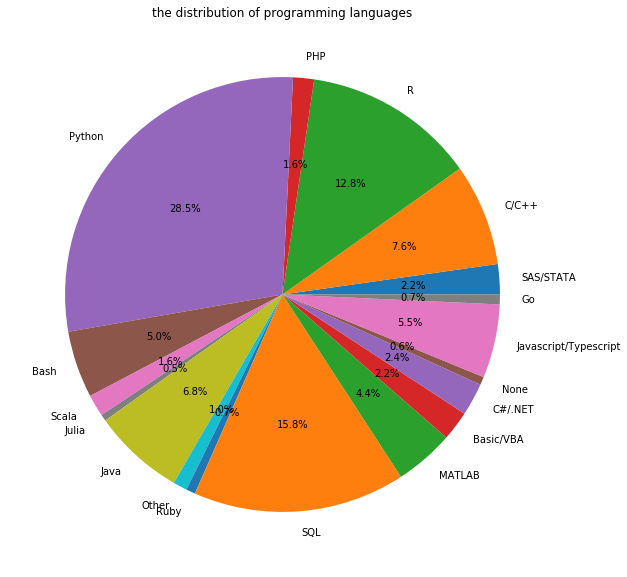

In [13]:
# first, count the number of different of language subjects use
cols = []
for col in data.columns:
    if "What programming languages do you use on a regular basis?" in col:
        cols.append(col)
        
# I find out that col "What programming languages do you use on a regular basis? (Select all that apply)
# - Other - Text" contains different type of information for this question, So for the statstic purpose, I delete
# this column
cols.remove('What programming languages do you use on a regular basis? (Select all that apply) - Other - Text')
statistic = {}
for col in cols:
    lang = col.split(' ')[-1]
    value = data[col].values.sum()
    statistic[lang] = value

keys = statistic.keys()
values = []
for key in keys:
    values.append(statistic[key])
    
plt.figure(figsize= [10,10])
plt.pie(values, labels = keys, autopct = '%1.1f%%', startangle = 90)
plt.title("the distribution of programming languages")
plt.show()

From above figure we can see that, first 3 most popular programming language for data analysis are python(28.5%), SQL(15.8%) and R(12.8%)

## 2.2 Visualize the order of feature importance
### I use correlation matrix between the label vectors and features to indicate feature importance

### First, extract labels out of all features data.

In [14]:
labels = data["What is your current yearly compensation (approximate $USD)?"]

### seoncd compute the correlation matrix between the label and feature

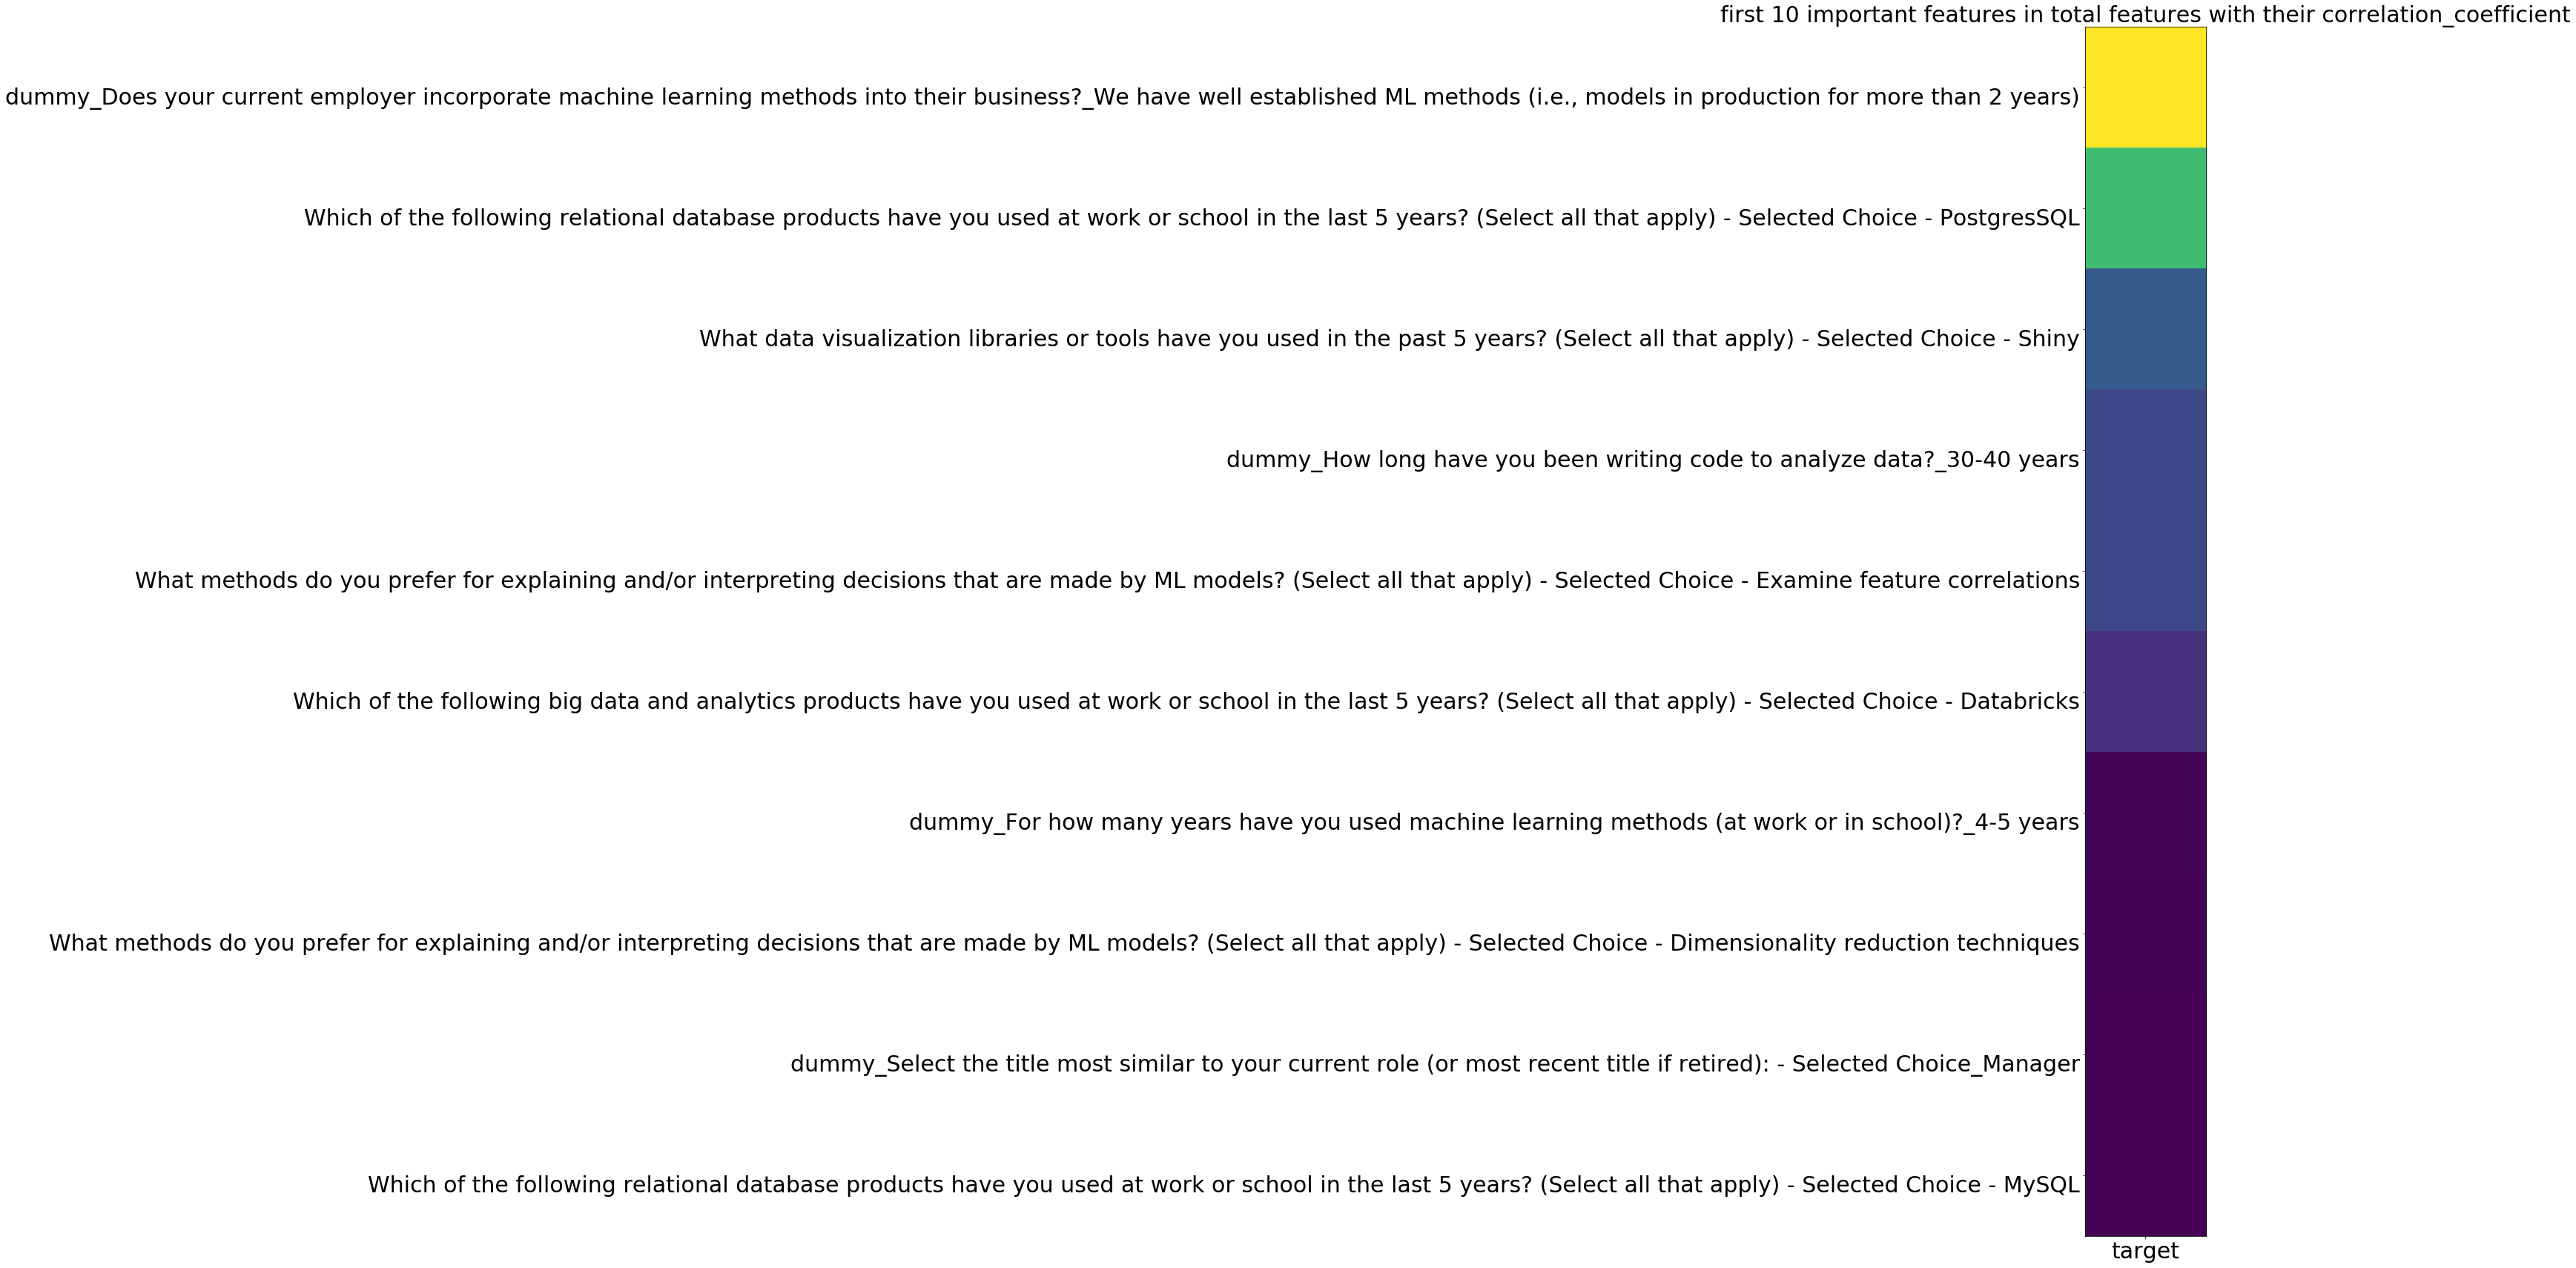

In [15]:
correlation_mat = {}
for col in data.columns:
    correlation_mat[col] = data[col].corr(labels)
correlation_mat = correlation_mat.items()
correlation_mat = sorted(correlation_mat, key = lambda x:x[1], reverse = True)
correlation_coefficient = [i[1] for i in correlation_mat]
related_name = [i[0] for i in correlation_mat]
showing_number = 10


# I have totally 793 features, in order to show importance appropriately, I will only plot 20 most important features
showing_mat = np.array(correlation_coefficient[:showing_number])
showing_mat = np.expand_dims(showing_mat,axis=0).T


fig, ax = plt.subplots(figsize = [10,30])
im = ax.imshow(showing_mat)

# We want to show all ticks...
ax.set_xticks(np.arange(showing_mat.shape[1]))
ax.set_yticks(np.arange(showing_mat.shape[0]))

# ... and label them with the respective list entries
ax.set_xticklabels(["target"],fontsize = 30, verticalalignment='top')
ax.set_yticklabels(related_name[:showing_number],fontsize = 30, verticalalignment='top', horizontalalignment='right')


#for i in range(showing_mat.shape[0]):
    #text = ax.text(0, i, showing_mat[i, 0], horizontalalignment="center", verticalalignment="center", color="w")

plt.title("first %d important features in total features with their correlation_coefficient"%(showing_number), fontsize = 30)
plt.show()

### So according to figure above, the more important features will be...

In [16]:
print("the first %d important features with their correlation coefficient:\n"%(showing_number))
for item in correlation_mat[:showing_number]:
    print(item[0]," ", item[1], "\n")

the first 10 important features with their correlation coefficient:

dummy_Does your current employer incorporate machine learning methods into their business?_We have well established ML methods (i.e., models in production for more than 2 years)   0.26947142708363087 

Which of the following relational database products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - PostgresSQL   0.22490543246690567 

What data visualization libraries or tools have you used in the past 5 years? (Select all that apply) - Selected Choice - Shiny   0.165884493069958 

dummy_How long have you been writing code to analyze data?_30-40 years   0.15648172493393203 

What methods do you prefer for explaining and/or interpreting decisions that are made by ML models? (Select all that apply) - Selected Choice - Examine feature correlations   0.15605275241639677 

Which of the following big data and analytics products have you used at work or school in the last 5 y

# Feature selection

## 3.0 Drop outliers before feature selection
from above distribution of the label values, I find that there are some outliers sample in the data set. To improve the preformance of predictation model, I will manual drop those outliters which too far away from main subjects.

After observation, I choose to drop the samples whose current yearly compensation are higher than 350000.

In [17]:
data = data[data["What is your current yearly compensation (approximate $USD)?"] <= 350000]
print("remain data:", data.shape)

# after drop outliers, extract the label output of dataset
labels = data.pop("What is your current yearly compensation (approximate $USD)?")

remain data: (7098, 688)


## 3.1 first, do feature scaling
Before feature selection, I would like do the feature scaling first. We have lots of features while different features have different scales. I will use Min-Max Scaling to rescale my features to range 0 to 1.

In [18]:
for col in data.columns:
    # var == 0 mean there are only one unique value in this columns, it will do no condirbution to regression, just drop it
    if data[col].var() == 0:   
        data.drop(columns = [col])
    else:
        data[col] = (data[col]-data[col].min())/(data[col].max()-data[col].min())
data.head(20)

,Duration (in seconds),What is your gender? - Prefer to self-describe - Text,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,...,"dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Prophet","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_PyTorch","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Scikit-Learn","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Spark MLlib","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_TensorFlow","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_Xgboost","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_catboost","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_lightgbm","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_mlr","dummy_Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice_randomForest"
1,0.000870,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000891,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002616,0.0,0.003484,0.003752,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.001046,0.0,0.000000,0.005629,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.002883,0.0,0.000000,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.001600,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.003274,0.0,0.005807,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.001892,0.0,0.000000,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.003128,0.0,0.006969,0.009381,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.005147,0.0,0.000000,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.2 split data into training data and test data

In [62]:
# copy the values first so that we don't need to modify previous data
X = data
Y = labels

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1624)

### transform they into numpy matrix

In [64]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

## 3.3 features selections

I will regularized regression (Lasso) to do the features selection. 

LASSO use a L1 regularized regression to automatically determine which features to drop by threaholds.

The reason why I choice LASSO is that it can get rid of unimportant features from regression perspective, which is what we asked to do in this assignment.

In [65]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(cv=5)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X_train, Y_train)
X_train = sfm.transform(X_train)

# also transform for X_test data
X_test = sfm.transform(X_test)

In [66]:
print("the selected number of features:", X_train.shape[1])

the selected number of features: 245


In [ ]:
# ## 3.4 Dimensionality Reduction
# As we can see there are still in high dimensions, then I will use PCA to reduce dimensions. 

In [61]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 200)
# pca.fit(X_train)
# X_train = pca.fit_transform(X_train)

# # also transform for X_test data
# X_test = pca.fit_transform(X_test)

# print("The shape of final training data:", X_train.shape)

## 3.5 justification

1. Firstly, we run the features scaling on data. There are totally 793 features after data cleaning. Some of their scales are pretty big while some of them are only between 0 to 1. The data with big scale will turn out to take more weight in the train, which is not what we want to see. After features scaling, we make all features have same scaling with 0 as mean, 1 as variance. So now, they will have same weight before put them into training process.


2. Second, we get 363 features out of totally 793 features by apply the LASSO algorithm with threshold of 0.25. Basicly, we fit the data to a L1 regularized regression models. Since L1 regularized has a squared solution space, some of the features will have nearly 0 weights(close to axis). Then, we set a threshold to drop features whose weight are smaller the threshold.


2. Third, after LASSO, our features' dimensions are still quite big. Therefore, PCA is implemented to reduce data dimension from 363 to 200. The PCA will comppress the data dimension so we can keep the most of data information while droping lots of features. Therefore, this process will speed up the training process.

# 4. Model implementation

In [199]:
from sklearn.model_selection import KFold
def bias(Y_predict,Y_true):
    return np.mean((Y_predict-Y_true)**2)

def var(Y_predict):
    Y_mean = np.mean(Y_predict)
    return np.mean((Y_predict-Y_mean)**2)

## 4.1 implement linear regression on data
use 10-folds cross validation to train a linear regression model on data

### 1. what it does?

linear regression will try to fit the data with equation 'Y=a+bX' using least squares error.

### 2. its pros and cons？

pros: fast, easy to compute
cons: because it equation is simply linear, it may not get good results when fitting complex data.

### 3. why you chose that algorithm?

It is simple, easy to implement and can also use as baseline form other complex model.

In [200]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def linearRegression(X,Y):
    accuracyList = []
    biasList = []
    varList = []
    MSEList = []
    kf = KFold(n_splits = 10)
    
    for trainIndex, testIndex in kf.split(X):
        X_trainFold, X_testFold = X[trainIndex], X[testIndex]
        Y_trainFold, Y_testFold = Y[trainIndex], Y[testIndex]
        
        # model 
        model = LinearRegression()
        
        # fitting 
        model.fit(X_trainFold, Y_trainFold)
        
        # record the R^2 score of each folds
        accuracyList.append(model.score(X_testFold,Y_testFold))
        
        # record the bias, var list
        Y_trainPredict = model.predict(X_trainFold)
        Y_testPredict = model.predict(X_testFold)
        biasList.append(bias(Y_trainPredict, Y_trainFold))
        varList.append(var(Y_trainPredict))
        
        # record the MSE
        MSEList.append(np.sqrt(mean_squared_error(Y_testFold, Y_testPredict)))
        print("finished")
        
    # compute the average of everything
    accuracyList = np.array(accuracyList)
    biasList = np.array(biasList)
    varList = np.array(varList)
    MSEList = np.array(MSEList)
    accuracyAver = np.mean(accuracyList)
    accuracyVar = np.var(accuracyList)
    biasAver = np.mean(biasList)
    varAver = np.mean(varList)
    MSEAver = np.mean(MSEList)
    return accuracyList, accuracyAver, accuracyVar, biasList, varList, biasAver, varAver, MSEAver

In [201]:
# train the linear regression model
accuracyListLR, accuracyAverLR, accuracyVarLR, biasListLR, varListLR, biasAverLR, varAverLR, MSEAverLR  = linearRegression(X_train,Y_train)

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [203]:
print("Average of accuracy (R2) for folds:", accuracyAverLR)
print("Variance of accuracy (R2) for folds:", accuracyVarLR)
print("Average MSE for folds:", MSEAverLR)
print("Average bias for folds", biasAverLR)
print("Average variance for folds", varAverLR)

Average of accuracy (R2) for folds: 0.6417334702437204
Variance of accuracy (R2) for folds: 0.0005954900825713798
Average MSE for folds: 35451.052118298496
Average bias for folds 1110800390.4892397
Average variance for folds 2420080560.2711163


In [68]:
# ## 4.2 implement support vector regression model on data
# use 10-folds cross validation to train a support vector regression (SVR) model on data

# ### 1. what it does?

# SVR based on support vector machine (SVM). It will try to fit the data with a hyper plane while minimize the distance between the data points and hyper plane.

# ### 2. its pros and cons？

# pros: can handle non-linear data by using kernel function.
# cons: more time comsumming than linear regression

# ### 3. why you chose that algorithm?

# SVR has a good preformance on fitting non-linear data, which mean it could out preformance linear regression model 

In [69]:
# from sklearn.svm import SVR
# def supportVectorRegression(X,Y):
#     accuracyList = []
#     biasList = []
#     varList = []
#     MSEList = []
#     kf = KFold(n_splits = 10)
    
#     for trainIndex, testIndex in kf.split(X):
#         X_trainFold, X_testFold = X[trainIndex], X[testIndex]
#         Y_trainFold, Y_testFold = Y[trainIndex], Y[testIndex]
        
#         # model
#         model = SVR(kernel = 'linear', C = 0.5, epsilon = 0.3,  gamma = 'auto')
        
#         # fitting 
#         model.fit(X_trainFold, Y_trainFold)
        
#         # record the R^2 score of each folds
#         accuracyList.append(model.score(X_testFold,Y_testFold))
        
#         # record the bias, var list
#         Y_trainPredict = model.predict(X_trainFold)
#         Y_testPredict = model.predict(X_testFold)
#         biasList.append(bias(Y_trainPredict, Y_trainFold))
#         varList.append(var(Y_trainPredict))
        
#         # record the MSE
#         MSEList.append(np.sqrt(mean_squared_error(Y_testFold, Y_testPredict)))
#         print("finished")
        
#     # compute the average of everything
#     accuracyList = np.array(accuracyList)
#     biasList = np.array(biasList)
#     varList = np.array(varList)
#     MSEList = np.array(MSEList)
#     accuracyAver = np.mean(accuracyList)
#     accuracyVar = np.var(accuracyList)
#     biasAver = np.mean(biasList)
#     varAver = np.mean(varList)
#     MSEAver = np.mean(MSEList)
#     return accuracyList, accuracyAver, accuracyVar, biasList, varList, biasAver, varAver, MSEAver

In [70]:
# # training
# accuracyListSVR, accuracyAverSVR, accuracyVarSVR, biasListSVR, varListSVR, biasAverSVR, varAverSVR, MSEAverSVR  = supportVectorRegression(X_train,Y_train)

In [71]:
# print(accuracyListSVR)

In [72]:
# print("Average of accuracy (R2) for folds:", accuracyAverSVR)
# print("Variance of accuracy (R2) for folds:", accuracyVarSVR)
# print("Average MSE for folds:", MSEAverSVR)
# print("Average bias for folds", biasAverSVR)
# print("Average variance for folds", varAverSVR)

## 4.2 implement gradient boosting regression model on data
use 10-folds cross validation to train a gradient boosting regression model on data

### 1. what it does?

gradient boosting regression compute the given loss functions on residual between predictions of last model and ture value and keep changing the weight of features to get a stronger regression model  

### 2. its pros and cons？

pros: it can implement different loss functions; robust to outliers
cons: it will be relatively slow when commputing high dimensional data

### 3. why you chose that algorithm?

it has a robust preformance when data has some outliers; by further changing different loss functions, it may have better results

In [33]:
from sklearn import ensemble
def gradientBoostingRegression(X,Y):
    accuracyList = []
    biasList = []
    varList = []
    MSEList = []
    kf = KFold(n_splits = 10)
    
    for trainIndex, testIndex in kf.split(X):
        X_trainFold, X_testFold = X[trainIndex], X[testIndex]
        Y_trainFold, Y_testFold = Y[trainIndex], Y[testIndex]
        
        # model
        model = ensemble.GradientBoostingRegressor(n_estimators = 600, loss = 'huber')
        
        # fitting 
        model.fit(X_trainFold, Y_trainFold)
        
        # record the R^2 score of each folds
        accuracyList.append(model.score(X_testFold,Y_testFold))
        
        # record the bias, var list
        Y_trainPredict = model.predict(X_trainFold)
        Y_testPredict = model.predict(X_testFold)
        biasList.append(bias(Y_trainPredict, Y_trainFold))
        varList.append(var(Y_trainPredict))
        
        # record the MSE
        MSEList.append(np.sqrt(mean_squared_error(Y_testFold, Y_testPredict)))
        print("finished")
        
    # compute the average of everything
    accuracyList = np.array(accuracyList)
    biasList = np.array(biasList)
    varList = np.array(varList)
    MSEList = np.array(MSEList)
    accuracyAver = np.mean(accuracyList)
    accuracyVar = np.var(accuracyList)
    biasAver = np.mean(biasList)
    varAver = np.mean(varList)
    MSEAver = np.mean(MSEList)
    return accuracyList, accuracyAver, accuracyVar, biasList, varList, biasAver, varAver, MSEAver

In [34]:
# training
accuracyListGBR, accuracyAverGBR, accuracyVarGBR, biasListGBR, varListGBR, biasAverGBR, varAverGBR, MSEAverGBR  = gradientBoostingRegression(X_train,Y_train)

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [35]:
print("Average of accuracy (R2) for folds:", accuracyAverGBR)
print("Variance of accuracy (R2) for folds:", accuracyVarGBR)
print("Average MSE for folds:", MSEAverGBR)
print("Average bias for folds", biasAverGBR)
print("Average variance for folds", varAverGBR)

Average of accuracy (R2) for folds: 0.5866618967130138
Variance of accuracy (R2) for folds: 0.0009311100146721463
Average MSE for folds: 38122.45506699797
Average bias for folds 465643569.49275047
Average variance for folds 2458931760.05888


## 4.3 implement random forest regression model on data
use 10-folds cross validation to train a random forest regressor model on data

### 1. what it does?

random forest regressor will train multiple trees to fitting the subset of training data. Then it will compute average of output of each tree to get final predict.

### 2. its pros and cons？

pros: it can handle high dimensional data and can decide the importances of the features itself
cons: it is slow since it need multiple trees to improve the performance; it is relatively easy to overfitting.

### 3. why you chose that algorithm?

our data has high dimension, and random forest can handle that just fine

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
def randomForestRegressor(X,Y):
    accuracyList = []
    biasList = []
    varList = []
    MSEList = []
    kf = KFold(n_splits = 10)
    
    for trainIndex, testIndex in kf.split(X):
        X_trainFold, X_testFold = X[trainIndex], X[testIndex]
        Y_trainFold, Y_testFold = Y[trainIndex], Y[testIndex]
        
        # model
        model = RandomForestRegressor(max_depth = 20, random_state = 1624, n_estimators = 80)
        
        # fitting 
        model.fit(X_trainFold, Y_trainFold)
        
        # record the R^2 score of each folds
        accuracyList.append(model.score(X_testFold,Y_testFold))
        
        # record the bias, var list
        Y_trainPredict = model.predict(X_trainFold)
        Y_testPredict = model.predict(X_testFold)
        biasList.append(bias(Y_trainPredict, Y_trainFold))
        varList.append(var(Y_trainPredict))
        
        # record the MSE
        MSEList.append(np.sqrt(mean_squared_error(Y_testFold, Y_testPredict)))
        print("finished")
        
    # compute the average of everything
    accuracyList = np.array(accuracyList)
    biasList = np.array(biasList)
    varList = np.array(varList)
    MSEList = np.array(MSEList)
    accuracyAver = np.mean(accuracyList)
    accuracyVar = np.var(accuracyList)
    biasAver = np.mean(biasList)
    varAver = np.mean(varList)
    MSEAver = np.mean(MSEList)
    return accuracyList, accuracyAver, accuracyVar, biasList, varList, biasAver, varAver, MSEAver

In [37]:
# training
accuracyListRFR, accuracyAverRFR, accuracyVarRFR, biasListRFR, varListRFR, biasAverRFR, varAverRFR, MSEAverRFR  = randomForestRegressor(X_train,Y_train)

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [38]:
print("Average of accuracy (R2) for folds:", accuracyAverRFR)
print("Variance of accuracy (R2) for folds:", accuracyVarRFR)
print("Average MSE for folds:", MSEAverRFR)
print("Average bias for folds", biasAverRFR)
print("Average variance for folds", varAverRFR)

Average of accuracy (R2) for folds: 0.484001634792978
Variance of accuracy (R2) for folds: 0.0009035891509620485
Average MSE for folds: 42586.01819803689
Average bias for folds 262160106.92577204
Average variance for folds 2320779768.9030256


## 4.4 implement lasso regression on data
use 10-folds cross validation to train a lasso regression model on data

### 1. what it does?

It's a linear model trained with only L1 prior as regularizer. 

### 2. its pros and cons？

pros: compare to linear to basic linear regression model, it will get a more general model, which mean it may have a better performance on testing data.
cons: it can only fit the linear data, if data is not linear distribued, it may not get good results

### 3. why you chose that algorithm?

it is one of the basic linear regression model we have, and it may achieve good generalize result in short period of training.

In [40]:
from sklearn import linear_model
def LASSORegressor(X,Y):
    accuracyList = []
    biasList = []
    varList = []
    MSEList = []
    kf = KFold(n_splits = 10)
    
    for trainIndex, testIndex in kf.split(X):
        X_trainFold, X_testFold = X[trainIndex], X[testIndex]
        Y_trainFold, Y_testFold = Y[trainIndex], Y[testIndex]
        
        # model
        model = linear_model.Lasso(alpha=0.1)
        
        # fitting 
        model.fit(X_trainFold, Y_trainFold)
        
        # record the R^2 score of each folds
        accuracyList.append(model.score(X_testFold,Y_testFold))
        
        # record the bias, var list
        Y_trainPredict = model.predict(X_trainFold)
        Y_testPredict = model.predict(X_testFold)
        biasList.append(bias(Y_trainPredict, Y_trainFold))
        varList.append(var(Y_trainPredict))
        
        # record the MSE
        MSEList.append(np.sqrt(mean_squared_error(Y_testFold, Y_testPredict)))
        print("finished")
        
    # compute the average of everything
    accuracyList = np.array(accuracyList)
    biasList = np.array(biasList)
    varList = np.array(varList)
    MSEList = np.array(MSEList)
    accuracyAver = np.mean(accuracyList)
    accuracyVar = np.var(accuracyList)
    biasAver = np.mean(biasList)
    varAver = np.mean(varList)
    MSEAver = np.mean(MSEList)
    return accuracyList, accuracyAver, accuracyVar, biasList, varList, biasAver, varAver, MSEAver

In [41]:
# training
accuracyListLASSOR, accuracyAverLASSOR, accuracyVarLASSOR, biasListLASSOR, varListLASSOR, biasAverLASSOR, varAverLASSOR, MSEAverLASSOR  = LASSORegressor(X_train,Y_train)

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [42]:
print("Average of accuracy (R2) for folds:", accuracyAverLASSOR)
print("Variance of accuracy (R2) for folds:", accuracyVarLASSOR)
print("Average MSE for folds:", MSEAverLASSOR)
print("Average bias for folds", biasAverLASSOR)
print("Average variance for folds", varAverLASSOR)

Average of accuracy (R2) for folds: 0.6304739588290719
Variance of accuracy (R2) for folds: 0.0007142970840265761
Average MSE for folds: 36002.75845699284
Average bias for folds 1179587682.9786217
Average variance for folds 2351090697.323517


## 4.5 model comparison

### 4.5.1 R2 result visualization
visualize the boxplots of r2 results acrossing 10 folds for each model

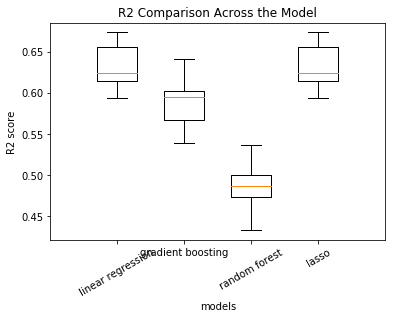

In [161]:
fig = plt.figure()
ax = plt.axes()

# linear
bp = plt.boxplot(accuracyListLR, positions = [1], widths = 0.6)

# gradient boosting
bp = plt.boxplot(accuracyListGBR, positions = [2], widths = 0.6)

# random forest
bp = plt.boxplot(accuracyListRFR, positions = [3], widths = 0.6)

# LASSO
bp = plt.boxplot(accuracyListLASSOR, positions = [4], widths = 0.6)

# set axes limits and labels
plt.xlim(0,5)
#plt.ylim(0.4,0.8)
ax.set_xticklabels(['linear regression', 'gradient boosting', 'random forest', 'lasso'], rotation = 30)
ax.set_xticks([1, 2, 3, 4])
plt.title( "R2 Comparison Across the Model")
plt.ylabel("R2 score")
plt.xlabel("models")
plt.show()

### 4.5.2 average of R2 score and variance of R2 score visualization
visualize average and variance of R2 score for each model

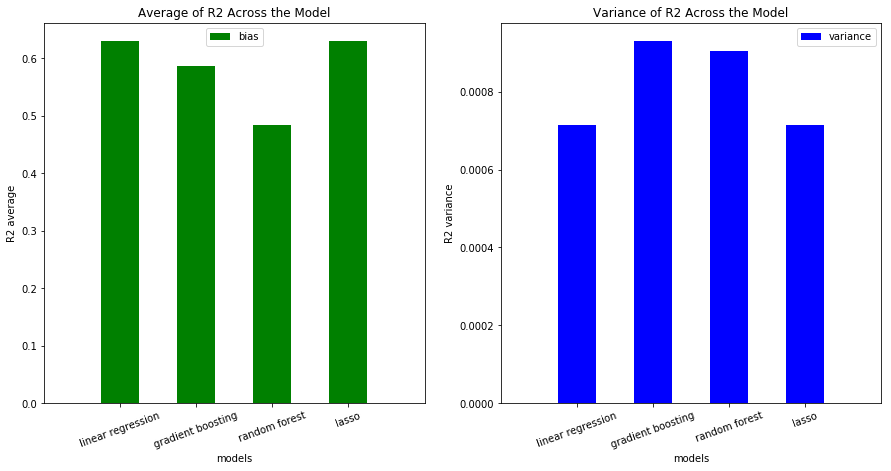

In [181]:
fig,ax = plt.subplots(1,2, figsize = (15,7))

average = [accuracyAverLR, accuracyAverGBR, accuracyAverRFR, accuracyAverLASSOR]
var = [accuracyVarLR, accuracyVarGBR, accuracyVarRFR, accuracyVarLASSOR]
xaxis = [1,2,3,4]

# set axes limits and labels
ax[0].set_xlim(0,5)
ax[1].set_xlim(0,5)

# plot 
ax[0].bar(x = xaxis, height = average, label='bias', color='green', width=0.5)
ax[1].bar(x = xaxis, height = var, label='variance', color='blue', width=0.5)
ax[0].set_xticklabels(['linear regression', 'gradient boosting', 'random forest', 'lasso'], rotation = 20)
ax[0].set_xticks([1, 2, 3, 4])
ax[1].set_xticklabels(['linear regression', 'gradient boosting', 'random forest', 'lasso'], rotation = 20)
ax[1].set_xticks([1, 2, 3, 4])

ax[0].set_xlabel("models")
ax[0].set_ylabel("R2 average")
ax[1].set_xlabel("models")
ax[1].set_ylabel("R2 variance")

ax[0].legend()
ax[1].legend()
ax[0].set_title( "Average of R2 Across the Model")
ax[1].set_title( "Variance of R2 Across the Model")
plt.show()

From above 4.5.1 and 4.5.2 we can see that, linear regression and lasso regression have the better R2 score performance judge by R2 score perspective. And random forest preformance worst among them.

### 4.5.3 Bias, variance and total error visualization
visualize the boxplots of average bias, average variance and total average error (bias + var) results for each model

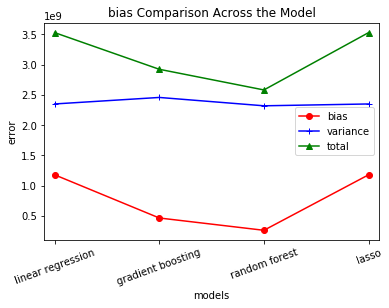

In [165]:
fig = plt.figure()
ax = plt.axes()

bias = [biasAverLR, biasAverGBR, biasAverRFR, biasAverLASSOR]
var = [varAverLR, varAverGBR, varAverRFR, varAverLASSOR]
total = [biasAverLR + varAverLR, biasAverGBR + varAverGBR, biasAverRFR + varAverRFR, biasAverLASSOR + varAverLASSOR]
xaxis = [1,2,3,4]

# set axes limits and labels
plt.xlim(0.9,4.1)

# plot 
plt.plot(xaxis, bias,'ro-', label='bias')
plt.plot(xaxis, var,'b+-', label='variance')
plt.plot(xaxis, total,'g^-', label='total')

ax.set_xticklabels(['linear regression', 'gradient boosting', 'random forest', 'lasso'], rotation = 20)
ax.set_xticks([1, 2, 3, 4])
plt.legend()
plt.title( "bias Comparison Across the Model")
plt.xlabel("models")
plt.ylabel("error")
plt.show()

So from plot above, the random forest regressor model has the lowest total error, judge from bais-variance perspective. Meanwhile, linear regression and lasso regression have high total error. The bias of each model are the main reason they are different while each model has similar variance.

### Therefore, based model will random forest from the bais-variance perspective since random forest regressor has the lowest bias among all 4 models and relatively lowest variance as well

# 5. Model tuning
In this pare, I will use grid search to do the hyperparameter tuning and select a final optimal model

Then, I will compute R^2 (coefficient of determination) and RMSE (root mean squared error) to compare the model performance

## 5.1 linear regression hyperparameter tuning
as we check the sklearn online document, the linear regression model has no hyperparameters. Therefore their is nothing for us to tuning and the model we get from previous part are already optimal one. We can use test data directly compute the R2 and RMSE.

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def linearRegression(X,Y):
    accuracyList = []
    biasList = []
    varList = []
    MSEList = []
    kf = KFold(n_splits = 10)
    
    for trainIndex, testIndex in kf.split(X):
        X_trainFold, X_testFold = X[trainIndex], X[testIndex]
        Y_trainFold, Y_testFold = Y[trainIndex], Y[testIndex]
        
        # model 
        model = LinearRegression()
        
        # fitting 
        model.fit(X_trainFold, Y_trainFold)
        
        # record the R^2 score of each folds
        accuracyList.append(model.score(X_testFold,Y_testFold))
        
        # record the bias, var list
        Y_trainPredict = model.predict(X_trainFold)
        Y_testPredict = model.predict(X_testFold)
        biasList.append(bias(Y_trainPredict, Y_trainFold))
        varList.append(var(Y_trainPredict))
        
        # record the MSE
        MSEList.append(np.sqrt(mean_squared_error(Y_testFold, Y_testPredict)))
        print("finished")
        
    # compute the average of everything
    accuracyList = np.array(accuracyList)
    biasList = np.array(biasList)
    varList = np.array(varList)
    MSEList = np.array(MSEList)
    accuracyAver = np.mean(accuracyList)
    accuracyVar = np.var(accuracyList)
    biasAver = np.mean(biasList)
    varAver = np.mean(varList)
    MSEAver = np.mean(MSEList)
    return accuracyList, accuracyAver, accuracyVar, biasList, varList, biasAver, varAver, MSEAver
# train the linear regression model
_,accuracyAverLR,_ ,_ ,_ ,_ ,_ , MSEAverLR  = linearRegression(X_train,Y_train)

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [209]:
print("the R2 for optimal linear regression model is:", accuracyAverLR)
print("the RMSE for optimal linear regression model is:", MSEAverLR)

the R2 for optimal linear regression model is: 0.6417334702437204
the RMSE for optimal linear regression model is: 35451.052118298496


## 5.2 gradient boosting regression hyperparameter tuning
as we check the sklearn online document, there are 3 main hyperparameters we can tuning:
1. n_estimators: The number of boosting stages to perform. 
2. min_samples_leaf: The minimum number of samples required to be at a leaf node, it will may cause over fitting problem.
3. max_depth: The maximum depth of the individual regression estimators. it will interfere how well model fits the training data.

In [79]:
# tunning setup
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

param_matrix = {'n_estimators' : list(range(100,150+1,10)),
                'min_samples_leaf' : list(range(1,5+1,2)),
                'max_depth' : list(range(5,20+1,5))}
test_model = ensemble.GradientBoostingRegressor(loss = 'huber')
search_model = GridSearchCV(estimator = test_model,
                            param_grid = param_matrix,
                            scoring = 'r2',
                            cv = 3,
                            n_jobs = -1)

# searching
search_model.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_sa...       subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [81]:
# after fitting extract best model, params, and score
bestmodelGB = search_model.best_estimator_
bestParamsGB = search_model.best_params_
bestScoreGB = search_model.best_score_
print("best score on gradient boosting regression:", bestScoreGB)
print("best params for gradient boosting regression:",bestParamsGB)

best score on gradient boosting regression: 0.6615224686805808
best params for gradient boosting regression: {'n_estimators': 140, 'max_depth': 5, 'min_samples_leaf': 3}


## 5.3 random forest regression model hyperparameter tuning
as we check the sklearn online document, there are 3 main hyperparameters we can tuning:
1. n_estimators: The number of trees in the forest. Which indicate the complexity of the model.
2. min_samples_leaf: The minimum number of samples required to be at a leaf node, it will may cause over fitting problem.
3. max_depth: The maximum depth of the individual regression estimators. it will interfere how well model fits the training data.

In [94]:
# tunning setup
param_matrix = {'n_estimators' : list(range(110,140+1,10)),
                'min_samples_leaf' : list(range(1,5+1,2)),
                'max_depth' : list(range(18,30+1,2))}
test_model = RandomForestRegressor(random_state = 1624)
search_model = GridSearchCV(estimator = test_model,
                            param_grid = param_matrix,
                            scoring = 'r2',
                            cv = 3,
                            n_jobs = -1)

# searching
search_model.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=1624, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [110, 120, 130, 140], 'max_depth': [18, 20, 22, 24, 26, 28, 30], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [96]:
# after fitting extract best model, params, and score
bestmodelRF = search_model.best_estimator_
bestParamsRF = search_model.best_params_
bestScoreRF = search_model.best_score_
print("best score on gradient boosting regression:", bestScoreRF)
print("best params for gradient boosting regression:",bestParamsRF)

best score on gradient boosting regression: 0.6389980039263268
best params for gradient boosting regression: {'n_estimators': 140, 'max_depth': 22, 'min_samples_leaf': 3}


## 5.4 LASSO model hyperparameter tuning
as we check the sklearn online document, there are 1 main hyperparameters we can tuning:
1. alpha: Constant that multiplies the L1 term. 0 alpha means ordinary least square, higher the alpha, more significant regularized term is.

In [187]:
# tunning setup
param_matrix = {'alpha' : list(np.linspace(0.1, 30.0, 60))}
test_model = linear_model.Lasso()
search_model = GridSearchCV(estimator = test_model,
                            param_grid = param_matrix,
                            scoring = 'r2',
                            cv = 3,
                            n_jobs = -1)

# searching
search_model.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.1, 0.6067796610169491, 1.1135593220338984, 1.6203389830508477, 2.1271186440677967, 2.6338983050847458, 3.1406779661016953, 3.6474576271186443, 4.154237288135593, 4.661016949152542, 5.167796610169491, 5.6745762711864405, 6.18135593220339, 6.688135593220339, 7.194915254237288, ...101694915256, 27.972881355932206, 28.479661016949155, 28.986440677966105, 29.493220338983054, 30.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [188]:
# after fitting extract best model, params, and score
bestmodelLASSO = search_model.best_estimator_
bestParamsLASSO = search_model.best_params_
bestScoreLASSO = search_model.best_score_
print("best score on gradient boosting regression:", bestScoreLASSO)
print("best params for gradient boosting regression:",bestParamsLASSO)

best score on gradient boosting regression: 0.6396111415040009
best params for gradient boosting regression: {'alpha': 28.986440677966105}


## 5.5 visualization and comparison

### 5.5.1 plot R2 (coefficient of determination) of the best tuned models

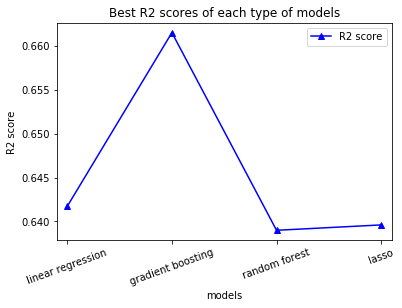

In [210]:
fig = plt.figure()
ax = plt.axes()

r2 = [accuracyAverLR, bestScoreGB, bestScoreRF, bestScoreLASSO]
xaxis = [1,2,3,4]

# set axes limits and labels
plt.xlim(0.9,4.1)

# plot 
plt.plot(xaxis, r2,'b^-', label='R2 score')

ax.set_xticklabels(['linear regression', 'gradient boosting', 'random forest', 'lasso'], rotation = 20)
ax.set_xticks([1, 2, 3, 4])
plt.legend()
plt.title( "Best R2 scores of each type of models")
plt.xlabel("models")
plt.ylabel("R2 score")
plt.show()

So from above plot, gradient boosting regression model gets the highest R2 score among all 4 types of model. Therefore I will choose  gradient boosting regression model to continue in section 6.

As for reason why linear model has the best performance, I think is that the original data and label are not in linear relationship, which let basic linear regression model and lasso regression model(linear model + regluarzation) achieve not-very-good result. And another reason why it's getting good results is that in our data, we have some outliers sample which will have relatively big influence on finally results and will make regression results unstable. But in gradient boosting regression, it can handle those outliers very well and so that build a robust regression model.  

# 6. Testing & Discussion

## 6.1 Testing. Train the gradient boosting gression model on whole training data with optimal prarmeters. And then, use trained model to make prediction on test data.

In [227]:
def gradientBoostingRegression(X_train,Y_train,X_test,Y_test):
    biasTrain = 0
    biasTest = 0
    varTrain = 0
    varTest = 0
    RMSETrain = 0
    RMSETest = 0
    R2Train = 0
    R2Test = 0
    
    # model
    model = ensemble.GradientBoostingRegressor(n_estimators = 140, loss = 'huber',max_depth = 5, min_samples_leaf = 3) # best prarmeters

    # fitting 
    model.fit(X_train, Y_train)
    
    # predict on training and testing set
    Y_trainPredict = model.predict(X_train)
    Y_testPredict = model.predict(X_test)
    
    # record the R2
    R2Train = model.score(X_train, Y_train)
    R2Test = model.score(X_test, Y_test)

    # record the bias, var
    biasTrain = bias(Y_trainPredict, Y_train)
    biasTest = bias(Y_testPredict, Y_test)
    varTrain = var(Y_trainPredict)
    varTest = var(Y_testPredict)
    
    # record the RMSE test
    RMSETrain = np.sqrt(mean_squared_error(Y_train, Y_trainPredict))
    RMSETest = np.sqrt(mean_squared_error(Y_test, Y_testPredict))
    
    # put them into data frame
    d = {"Bias":[biasTrain, biasTest],"Variance":[varTrain, varTest],"RMSE":[RMSETrain, RMSETest], "R2":[R2Train,R2Test]}
    df = pd.DataFrame(d,index=['Train', 'Test'])
    return df

In [228]:
final_df = gradientBoostingRegression(X_train,Y_train,X_test,Y_test)

## 6.2 Discussion

### 1. How my model perform on the train set vs. test set?

In [229]:
final_df.head()

,Bias,R2,RMSE,Variance
Train,6.231759e+08,0.823512,24963.491782,2.467954e+09
Test,1.239513e+09,0.646788,35206.721995,2.333225e+09


The gradient boosting regression model results are shown in form above. The results indicate a relatively high bias and high variance model. R2 score looks good on training set, but drop a lot on test set..The RMSE on test set is35206.721995 while only 24963.491782 on training set.

### 2. Is it overfitting or underfitting?

From above form, we can see that the test bias, test R2 score and test RMSE are much higher than the train bias, train R2 score and train RMSE, respactively. That indicate overfitting may occur on the training processing. Because both indicators point out that training performance better that testing performance. That means our gradient boosting regression model fitting better on training data, but when we give new data, such as test data to it, its accuracy drops. Our model learning to much details about training data, lead itself not generalize enough for new data.

### 3. The overall fit of the model, how to increase the accuracy (test, training)?

#### 1. To increase test accuracy:

From the analysis above, we know that our traing model are overfitting a lot. Therefore, we can add some regularize processing or setup to prevent overfitting during training step. If model is regularized enough, the test accuracy will increase.

To be specific, for gradient boosting regression model, during the training, we can decrease the maximum value of the 'max_depth' or decrease the maximum value of 'n_estimators' to prevent model learn too much details on training data. And also early stop can also be a good processing to prevent overfitting.


#### 2. To increase training accuracy:

If we don't care about over fitting problem and just want to gain higher accuracy on training set, we can make each 'estimators' in gradient boosting go deeper and deeper until it learns all details information on training data. However, this is not what we want. We want our model has good performance on not only training data set, but also on test data set.

To do that, I think it will not just about improve actual training processing. We also need to improve the data clear processing and feature selection processing. One way is to find a better way to get clearer data (since all original data are pretty 'dirty'). Then use a better way to extract useful information out of original 'dirty' data. Feature selection will be helpful since it can get rid of unencessary information. As for dimension reduce processing, only choose those lossless compression method instead of lossy compression method like(PCA). To get rid of dimension compression method like PCA will cost you more time to train model, but it actually may increase a little bit accuracy.